In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
import joblib
from collections import Counter
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
from platform import python_version
print(python_version())

3.8.6


## Load feature table

Note that features are merged if they are perfectly correlated with each other. We call the merged features "Pattern".

In [3]:
df_X = pd.read_csv("data/pattern_all_isolates.csv", index_col=0).astype(int)
df_X.head()

,Pattern_206,Pattern_1,Pattern_114,Pattern_667,Pattern_139,Pattern_8,Pattern_81,Pattern_30,Pattern_3,Pattern_57,...,Pattern_3717,Pattern_3718,Pattern_3719,Pattern_3720,Pattern_3721,Pattern_3722,Pattern_3723,Pattern_3724,Pattern_3725,Pattern_3726
Isolate,,,,,,,,,,,,,,,,,,,,,
CDC335,0,0,0,1,0,0,1,0,0,0,...,2,2,2,2,2,2,2,2,2,2
CDC336,0,0,0,1,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2
CDC337,0,0,0,1,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2
CDC338,0,0,0,1,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2
CDC339,0,0,0,1,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2


## Load dictionary mapping raw features to merged features (Patterns)

In [4]:
feature2pattern = joblib.load("data/feature2pattern.all.joblib")
df_mapping = pd.DataFrame.from_dict(feature2pattern, orient="index").reset_index()
df_mapping.columns = ['Raw','Merged']
raw_feature_counter = dict(Counter(df_mapping.Merged))
df_mapping.head()

,Raw,Merged
0,CNV_cat__CPAR2_100030=1,Pattern_82
1,CNV_cat__CPAR2_100030=2,Pattern_684
2,CNV_cat__CPAR2_100070=1,Pattern_82
3,CNV_cat__CPAR2_100100=2,Pattern_25
4,CNV_cat__CPAR2_100100=3,Pattern_1437


## Load heteroresistance phenotype

In [5]:
df_y = pd.read_csv('data/hr_phenotype.csv', index_col=0)
df_y.HR = df_y.HR.astype(int)
df_y = df_y.loc[df_X.index]
df_y.head()

,Institute,Location,HR
Isolate,,,
CDC335,CDC,USA,0
CDC336,CDC,USA,0
CDC337,CDC,USA,0
CDC338,CDC,USA,0
CDC339,CDC,USA,0


## Run logistic regression

Logistic regression was performed one feature at a time

In [6]:
df_Xy = pd.merge(df_X, df_y[['HR']], left_index=True, right_index=True, how='inner')

res = []
for k,p in enumerate(df_X.columns):
    feature = (';').join(np.sort([k for k,v in feature2pattern.items() if v==p]))
    X_train = df_Xy[[p]]
    y_train = df_Xy[['HR']]
    logit_model=sm.Logit(y_train,sm.add_constant(X_train))
    result=logit_model.fit(method='bfgs', disp=0)
    res.append([p, feature] + list(result.summary2().tables[1].loc[p].values))
df_res = pd.DataFrame(res, columns=['Pattern','Feature','Coef','Std','z','P','CI_lower','CI_upper'])
df_res = df_res[df_res.P.notnull()].set_index('Pattern') # features with null P values are removed

# multitest correction
p_values_ext = list(df_res.P)
for pat, pv in zip(df_res.index, df_res.P):
    count = raw_feature_counter[pat]
    if count > 1:
        p_values_ext.extend([pv]*(count-1))
df_res['Padj'] = multipletests(p_values_ext, method='bonferroni')[1][:len(df_res)]
df_res = df_res.sort_values('Padj')
df_res['Rank'] = np.arange(len(df_res))+1
df_res.head()

,Feature,Coef,Std,z,P,CI_lower,CI_upper,Padj,Rank
Pattern,,,,,,,,,
Pattern_4376,cpar_Chr_2:1291351:SNP:C:T=2,3.698444,0.402544,9.187671,4.014378e-20,2.909472,4.487416,2.403850e-15,1
Pattern_2154,CNV_cat__CPAR2_600440=3,3.807010,0.415237,9.168287,4.805952e-20,2.993161,4.620859,2.877852e-15,2
Pattern_573,cpar_Chr_1:273032:SNP:C:T=2;cpar_Chr_1:273038:...,3.735254,0.411542,9.076240,1.123900e-19,2.928647,4.541862,6.730024e-15,3
Pattern_5811,cpar_Chr_5:656439:SNP:C:T=2,3.540908,0.391338,9.048198,1.453466e-19,2.773899,4.307918,8.703501e-15,4
Pattern_543,cpar_Chr_1:274924:SNP:T:C=2;cpar_Chr_1:275024:...,3.465450,0.384487,9.013175,2.001748e-19,2.711869,4.219031,1.198667e-14,5


## Draw volcano plot

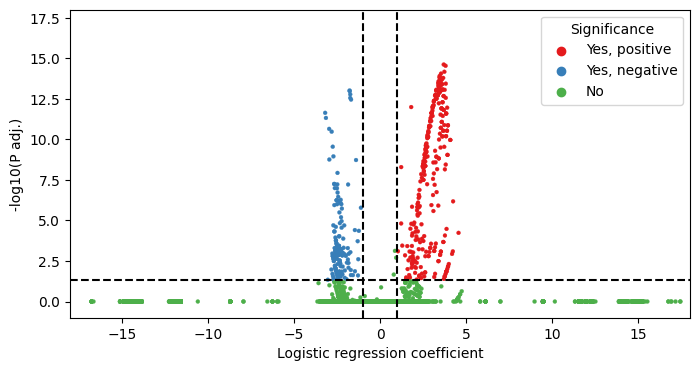

In [7]:
df2plot = deepcopy(df_res)
df2plot['neg_log10_Padj'] = -np.log10(df2plot.Padj)
df2plot['Significance'] = 'No'
df2plot.loc[(df2plot.Coef>1) & (df2plot.neg_log10_Padj > -np.log10(0.05)), 'Significance'] = 'Yes, positive'
df2plot.loc[(df2plot.Coef<-1) & (df2plot.neg_log10_Padj > -np.log10(0.05)), 'Significance'] = 'Yes, negative'

fig, ax = plt.subplots(figsize=(8,4))
_ = sns.scatterplot(x="Coef", y="neg_log10_Padj", data=df2plot, s=8, edgecolor=None, facecolor='grey', hue='Significance', palette="Set1", ax=ax, hue_order=["Yes, positive","Yes, negative","No"])
_ = ax.plot([-1,-1],[-1,18],'k--')
_ = ax.plot([+1,+1],[-1,18],'k--')
_ = ax.plot([-18,+18],[-np.log10(0.05),-np.log10(0.05)],'k--')
_ = ax.set_xlim([-18,18])
_ = ax.set_ylim([-1,18])
_ = ax.set_xlabel('Logistic regression coefficient', fontsize=10)
_ = ax.set_ylabel('-log10(P adj.)', fontsize=10)

_ = plt.savefig("output/logit_volcano_plot.png", dpi=600, bbox_inches="tight")